<h1>Part 3: Feature engineering</h1>

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [22]:
df = pd.read_csv("train_cleaned.csv")
df["Review"] = df["Review"].astype(str)

In [23]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Review"])

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Scaling using MinMaxScaler
scaler = MinMaxScaler()
tfidf_df= pd.DataFrame(scaler.fit_transform(tfidf_df), columns=tfidf_df.columns)

In [24]:
variances = tfidf_df.var()
q3_threshold = np.percentile(variances, 75)
q3_threshold

np.float64(0.0012818434858380902)

In [25]:
variances.describe()

count    1000.000000
mean        0.001262
std         0.002132
min         0.000022
25%         0.000443
50%         0.000709
75%         0.001282
max         0.030683
dtype: float64

In [26]:
q3_threshold = np.percentile(variances, 75)

selector = VarianceThreshold(threshold=q3_threshold)
tfidf_df = selector.fit_transform(tfidf_df)

tfidf_df.shape

standardizer = StandardScaler(with_mean=False)
tfidf_df = standardizer.fit_transform(tfidf_df)

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA to compute all components (but don't reduce yet)
pca = PCA().fit(tfidf_df)

In [27]:
tfidf_df.shape

(81245, 249)

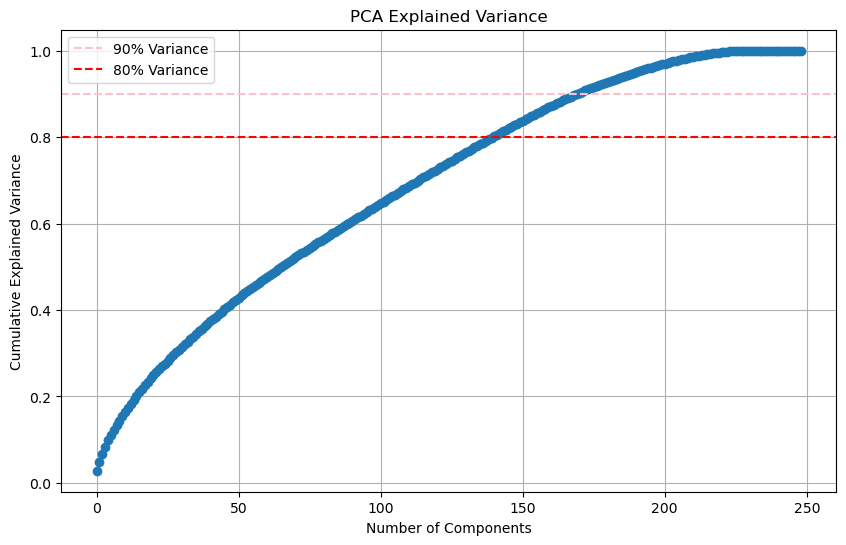

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.90, color='pink', linestyle='--', label='90% Variance')  # Common threshold
plt.axhline(0.80, color='red', linestyle='--', label='80% Variance')  # Common threshold
plt.title('PCA Explained Variance')
plt.legend()
plt.grid()
plt.show()

In [29]:
pca_80 = PCA(n_components=0.80)  
tfidf_df = pca_80.fit_transform(tfidf_df)
print(f"Reduced to {tfidf_df.shape[1]} components")

Reduced to 141 components


In [30]:
tfidf_df = pd.DataFrame(tfidf_df)
tfidf_df.shape

(81245, 141)

In [ ]:
df = pd.concat([tfidf_df, df[["Ratings"]]], axis=1)

In [32]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,132,133,134,135,136,137,138,139,140,Ratings
0,-0.615138,-0.188757,-0.237252,-0.115976,-0.084227,-0.095152,0.780428,-0.017289,0.040081,-0.092408,...,-1.206958,-1.046633,0.090597,-0.792991,0.322568,0.854454,-0.917398,0.889104,0.463468,5
1,0.314251,-0.246799,-0.200086,0.078230,-0.318854,0.224830,0.904092,0.120077,-0.091146,-0.050776,...,-1.766862,0.766078,-1.497686,1.138265,0.904838,0.115468,1.408287,1.279476,0.898846,5
2,-0.456931,-0.105878,-0.141986,0.006088,-0.026652,0.020236,-0.580081,-0.125991,0.143433,-0.193483,...,-0.000683,0.118035,0.317623,0.180115,0.106927,0.028436,0.119068,-0.004760,-0.025628,5
3,-0.643852,-0.232350,-0.280970,-0.125229,-0.060414,-0.162700,1.318512,0.116507,-0.078481,-0.447594,...,-0.769542,-0.004359,-0.477323,-0.049730,0.118101,-0.237830,-1.681672,-0.999342,0.169445,5
4,0.044872,1.388185,0.620258,0.013481,-0.288501,0.291975,-2.261457,2.395751,0.318156,-1.555205,...,0.418096,0.435288,0.329854,-0.538925,-0.118560,-0.058694,-1.209640,0.547666,-1.458867,4


In [34]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.3, random_state=2092)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score

# 1️⃣ Extract Features & Target
X_train = train_df.drop(columns=['Ratings'])
y_train = train_df['Ratings']

X_val = val_df.drop(columns=['Ratings'])
y_val = val_df['Ratings']

# 2️⃣ Train a Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')  # One-vs-Rest strategy
model.fit(X_train, y_train)

# 3️⃣ Make Predictions
y_pred = model.predict(X_val)      # Predicted classes
y_prob = model.predict_proba(X_val)  # Predicted probabilities for all classes

# 4️⃣ Evaluate Performance
auc_roc = roc_auc_score(y_val, y_prob, multi_class='ovr')  # AUC-ROC for multiclass
f1 = f1_score(y_val, y_pred, average='weighted')  # Weighted F1 Score

print(f"AUC-ROC Score: {auc_roc:.4f}")
print(f"F1 Score: {f1:.4f}")


/home/antoni/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


AUC-ROC Score: 0.7502
F1 Score: 0.6675


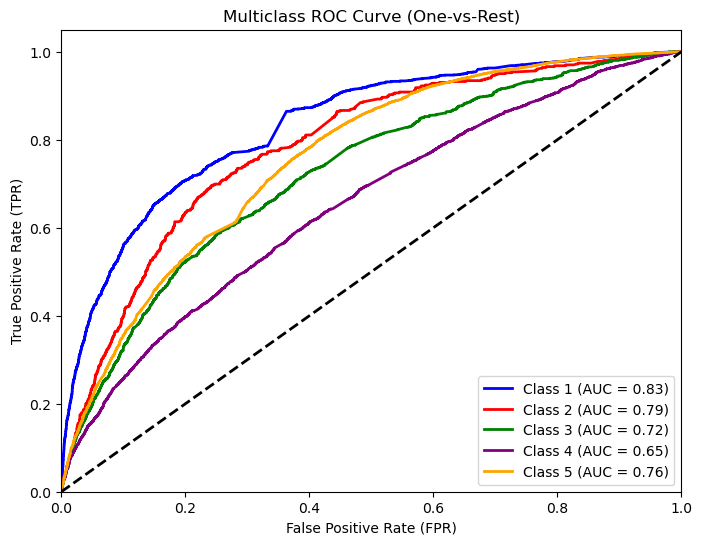

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1️⃣ Binarize the output (One-vs-Rest)
n_classes = len(y_train.unique())  # Number of unique classes (1-5)
y_val_bin = label_binarize(y_val, classes=np.arange(1, n_classes + 1))

# 2️⃣ Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange"])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# 3️⃣ Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, f1_score
import pandas as pd

# 1️⃣ Define models to test
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

# 2️⃣ Initialize results storage
results = []

# 3️⃣ Train & Evaluate Each Model
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_val)      # Class predictions
    y_prob = model.predict_proba(X_val)  # Probabilities for AUC-ROC
    
    # Compute metrics
    auc_roc = roc_auc_score(y_val, y_prob, multi_class='ovr')  # AUC-ROC for multiclass
    f1 = f1_score(y_val, y_pred, average='weighted')  # Weighted F1 score
    
    # Store results
    results.append({"Model": name, "F1 Score": f1, "AUC-ROC": auc_roc})

# 4️⃣ Save results to DataFrame
results_df = pd.DataFrame(results)

# 5️⃣ Display results
results_df

/home/antoni/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,F1 Score,AUC-ROC
0,Logistic Regression,0.667545,0.750233
1,Random Forest,0.662873,0.711848
2,Gradient Boosting,0.673578,0.765745
3,Naive Bayes,0.411034,0.629899
4,Decision Tree,0.637130,0.542102


In [41]:
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
    
    # Predictions
y_pred = model.predict(X_val)      # Class predictions
y_prob = model.predict_proba(X_val)  # Probabilities for AUC-ROC
    
    # Compute metrics
auc_roc = roc_auc_score(y_val, y_prob, multi_class='ovr')  # AUC-ROC for multiclass
f1 = f1_score(y_val, y_pred, average='weighted')

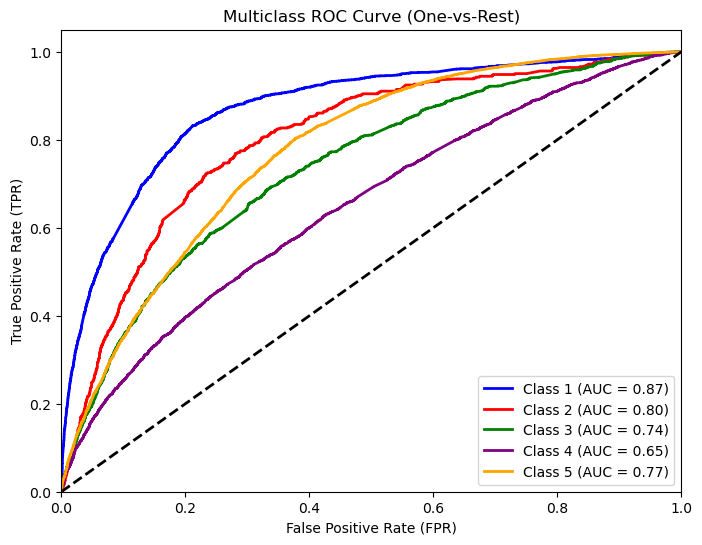

In [42]:
# 1️⃣ Binarize the output (One-vs-Rest)
n_classes = len(y_train.unique())  # Number of unique classes (1-5)
y_val_bin = label_binarize(y_val, classes=np.arange(1, n_classes + 1))

# 2️⃣ Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange"])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, lw=2, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# 3️⃣ Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random chance)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

In [43]:
auc_roc

np.float64(0.7657448858207762)

In [44]:
f1

0.6735783916070709